In [105]:
# imports and other setup
import numpy as np
import matplotlib.pyplot as plt

# pendulum class for parameters and dynamics
class furuta:
    def __init__(self):
        # parameters
        self.m1 = 0.01      # link 1 mass
        self.m2 = 0.02      # link 2 mass
        self.I1 = 0.0001    # link 1 inertia
        self.I21 = 0.0002   # link 2 inertia about axis 1
        self.I2z = 0.0001   # link 2 inertia about axis z
        self.l1 = 0.05      # length of link 1
        self.l2 = 0.10      # length of link 2
        self.c1 = 0         # distance to link 1 center of mass
        self.c2 = 0.05      # distance to link 2 center of mass
        self.b1 = 0.000008       # viscous friction in joint 1
        self.b2 = 0.000008      # viscous friction in joint 2
        self.g = 9.81       # acceleration due to gravity
        # pendulum state [q1,q2,dq1,dq2]
        self.state = np.array([0,0,0,0])
        # actuator torques
        self.torques = np.array([0,0])
    
    # helper functions    
    def mass_matrix(self):
        M11 = (self.I1 + self.I2z + (self.c1**2)*self.m1 + ((self.c2**2)*self.m2*0.5) 
              + (self.l1**2)*self.m2 - ((self.c2**2)*self.m2*np.cos(2*self.state[1]))*0.5)
        M12 = -self.c2*self.l1*self.m2*np.cos(self.state[1])
        M21 = -self.c2*self.l1*self.m2*np.cos(self.state[1])
        M22 = self.m2*(self.c2**2) + self.I21
        return np.array([[M11,M12],[M21,M22]])
    
    def coriolis_gravity(self):
        CG1 = (self.c2*self.state[3]*self.m2*(self.state[3]*self.l1*np.sin(self.state[1])
              + self.c2*self.state[2]*np.sin(2*self.state[1])))
        CG2 = (-((self.c2**2)*(self.state[2]**2)*self.m2*np.sin(2*self.state[1]))*0.5 
              - self.c2*self.g*self.m2*np.sin(self.state[1]))
        return np.array([[CG1],[CG2]])
    
    def friction(self):
        F1 = -self.b1*self.state[2]
        F2 = -self.b2*self.state[3]
        return np.array([[F1],[F2]])
    
    def calc_qdd(self):
        M = self.mass_matrix()
        CG = self.coriolis_gravity()
        F = self.friction()
        qdd = np.matmul(np.linalg.inv(M), self.torques.reshape((2,1)) + F - CG)
        return np.ravel(qdd)

    def kinetic_energy(self):
        T1 = ((self.state[2]**2)*(self.m1*(self.c1**2) + self.I1))*0.5
        T2 = ((self.I21*(self.state[3]**2))*0.5 + (self.I2z*(self.state[2]**2))*0.5 
             + ((self.c2**2)*(self.state[3]**2)*self.m2)*0.5 + ((self.c2**2)*(self.state[2]**2)*self.m2)*0.5
             + ((self.state[2]**2)*(self.l1**2)*self.m2)*0.5 - self.c2*self.state[3]*self.state[2]*self.l1*self.m2*np.cos(self.state[1])
             - ((self.c2**2)*(self.state[2]**2)*self.m2*(np.cos(self.state[1])**2))*0.5)
        return T1+T2
    
    def potential_energy(self):
        V = self.c2*self.g*self.m2*(np.cos(self.state[1]) + 1)
        return V
    
    def total_energy(self):
        E = self.kinetic_energy() + self.potential_energy()
        return E
    
    # do euler step here? torque calcs? could add methods for both 
    #def euler_step(self,dt):
    #def calc_control(self):
    

In [108]:
# function that takes in pendulum instance and returns torque calcs
def pendulum_controller(t,furuta):
    # get current state
    cur_state = furuta.state
    # calculate new torque
    new_torque = 0
    # store new torque
    furuta.torques[0] = new_torque
    return new_torque


In [113]:
# initialize pendulum 
pend = furuta()
pend.state = np.array([0,np.pi/2,0,0])

# set up integration
dt = 0.001
tf = 10
times = np.arange(0,tf,dt)

# store data
states = np.zeros((4,np.size(times)))
energies = np.zeros((3,np.size(times)))
torques = np.zeros(np.shape(times))

# run simulation
for i in range(np.size(times)):
    # store current state
    states[:,i] = pend.state
    # store current energies
    energies[0,i] = pend.kinetic_energy()
    energies[1,i] = pend.potential_energy()
    energies[2,i] = pend.total_energy()
    # below could all happen in the pendulum class...
    # calculate torque
    torques[i] = pendulum_controller(times[i],pend)
    # calculate qdd
    qdd = pend.calc_qdd()
    # euler step to update state
    qd = pend.state[2:4]   
    pend.state = pend.state + dt*np.concatenate((qd,qdd))


In [112]:
# animate 3D simulation?

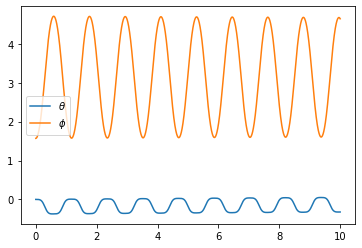

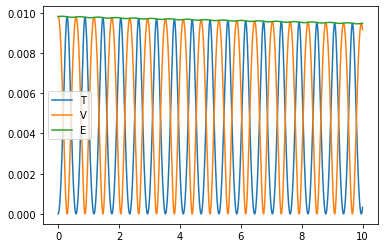

In [114]:
# plot angles and energies...anything else?

plt.plot(times,states[0,:],label=r'$\theta$')
plt.plot(times,states[1,:],label=r'$\phi$')
plt.legend()
plt.show()

plt.plot(times, energies[0,:],label='T') # note non-passivity of the Euler method
plt.plot(times, energies[1,:],label='V')
plt.plot(times, energies[2,:],label='E')
plt.legend()
plt.show()